In [1]:
from itertools import chain
from glob import glob

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
#import seawater as sw
import os

##### Anna's method

In [2]:
# READ files for oxygen, piControl run
dir_o2 = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Omon/o2/gn/latest'
dataset_o2 = xr.open_dataset(dir_o2 + '/o2_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-199912.nc')

# READ files for temperature, piControl run
dir_T = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Omon/thetao/gn/latest'
dataset_T = xr.open_dataset(dir_T + '/thetao_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-199912.nc')

# READ files for salinity, piControl run
dir_S = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Omon/so/gn/latest'
dataset_S = xr.open_dataset(dir_S + '/so_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-199912.nc')

# If you want assign variables for simplicity (you do not need to)
oxygen = dataset_o2['o2'][:,:,:,:]
time = dataset_o2['time']
T = dataset_T['thetao'][:,:,:,:]
S = dataset_S['so'][:,:,:,:]


In [3]:
# computing o_sat 
def o2sat2(T,S):
    
    T1 = (T + 273.15) / 100;
    # o2 from mol m-3 to UM/kg assume a density of 1025
    # but we can refine that estimating the actual density
    # o2_kg = ( o2 / 1025 ) *1E6
    
    osat = -177.7888 + 255.5907 / T1 + 146.4813 * np.log(T1) - 22.2040 * T1;
    osat = osat + S * (-0.037362 + T1 * (0.016504 - 0.0020564 * T1));
    osat = np.exp(osat);
    # o2_sat from ml/kg to mol/m^-3  
    # assume a density of 1025
    # but we can refine that estimating the actual density
    osat = osat *  1025 / (22.392 *1000);
    return osat

In [1]:
if os.path.isfile('Osat_output_files')==False:
    os.mkdir('Osat_output_files')
else:
    print('Folder exists')

In [13]:
# dummy time variable
ts = np.split(time, 20) # splits time dim to use as an index

In [45]:
%%time
for i in range(20):
    
    o_sat2 = o2sat2(T.sel(time=ts[i][:]), S.sel(time=ts[i][:])) # apply osat function. Should work for others
    
    o_sat2.to_netcdf('Osat_output_files/group_'+str(i)+'.nc')

CPU times: user 13min 12s, sys: 6min 20s, total: 19min 32s
Wall time: 20min 16s


##### compute AOU

In [5]:
osat_files = os.listdir('Osat_output_files')

for f in range(len(osat_files)):
    
    osat_files[f] = 'Osat_output_files/'+ osat_files[f] # the order doesn't matter, xarray
                                                        # will handle it.

In [7]:
# reread output - for some reason its slower using the original section output
oxygen_sat2 = xr.open_mfdataset(osat_files) # merges automatically along the time axis

In [34]:
#AOU = oxygen_sat2 - oxygen # this bit is also slow

def compute_AOU(oxygen, oxygen_sat, time_var):
    
    if os.path.isfile('AOU_output')==False:   
        os.mkdir('AOU_output')
    
    for i in range(20):
        AOU_files = oxygen_sat.sel(time=ts[i][:]) - oxygen.sel(time=ts[i][:])
        
        AOU_files.to_netcdf('AOU_output/'+'aou_group_'+str(i)+'_.nc')
    
    return AOU_files

In [35]:
%%time
compute_AOU(oxygen, oxygen_sat2, ts) # ~8mins. prints out the last time slice 

CPU times: user 5min 28s, sys: 2min 6s, total: 7min 35s
Wall time: 8min 20s


<xarray.Dataset>
Dimensions:                        (i: 360, j: 330, lev: 75, time: 24)
Coordinates:
  * lev                            (lev) float64 0.5058 1.556 ... 5.902e+03
  * j                              (j) int32 0 1 2 3 4 5 ... 325 326 327 328 329
  * i                              (i) int32 0 1 2 3 4 5 ... 355 356 357 358 359
    latitude                       (j, i) float32 -84.108955 ... 50.01094
    longitude                      (j, i) float32 73.5 74.5 ... 72.98915
  * time                           (time) object 1998-01-16 00:00:00 ... 1999-12-16 00:00:00
Data variables:
    __xarray_dataarray_variable__  (time, lev, j, i) float32 dask.array<shape=(24, 75, 330, 360), chunksize=(24, 75, 330, 360)>

In [37]:
aou_files = os.listdir('AOU_output')

for f in range(len(aou_files)):
    
    aou_files[f] = 'AOU_output/'+ aou_files[f] # the order doesn't matter, xarray
                                                        # will handle it.

In [40]:
AOU = xr.open_mfdataset(aou_files) # time is now the fourth dimension

In [58]:
section = AOU.sel(time=ts[0][0],lev=AOU.lev[8].values).to_array()

In [64]:
section.variable # I havent renamed this to AOU

<xarray.Variable (variable: 1, j: 330, i: 360)>
dask.array<shape=(1, 330, 360), dtype=float32, chunksize=(1, 330, 360)>

##### Plots just to sanity check the AOU

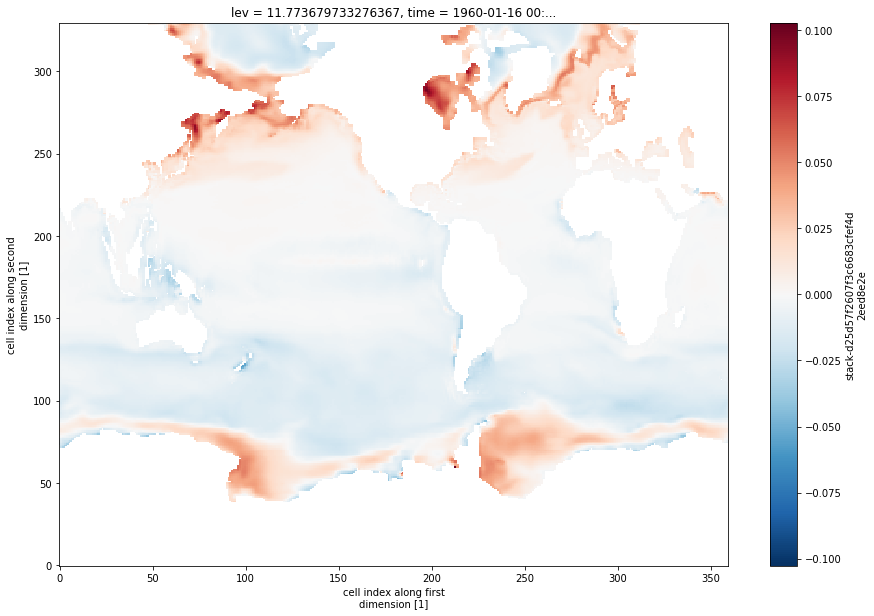

In [69]:
fig, ax = plt.subplots(1,1, figsize=[15,10])

plot = section.plot()
#plt.colorbar(plot)